https://www.kaggle.com/datasets/omermetinn/tweets-about-the-top-companies-from-2015-to-2020

In [1]:
# import pandas as pd
# tweets = pd.read_csv(r'C:\Users\Adil Rehman\OneDrive\Documents\Uni\ML\Dissertation\stock\tweets.csv')
# tweets['ticker_symbol'].unique()

array(['AAPL', 'AMZN', 'TSLA', 'MSFT', 'GOOG', 'GOOGL'], dtype=object)

In [3]:
import sys
sys.path.append(r'C:\Users\Adil Rehman\OneDrive\Documents\Uni\ML\Dissertation\stock\models')

import tool
tool.sound()
# Tool.email()

____
# NEW


In [3]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pytz
from datetime import datetime, time
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics import silhouette_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

nltk.download(['punkt', 'stopwords', 'wordnet'], quiet=True)

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)


Using device: cuda


In [5]:
from tqdm import tqdm 
import gc

# market hours
market_open = time(9, 30)
market_close = time(16, 0)

import time as Time

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['post_date'])
    df = df[df['ticker_symbol'].isin(['AAPL','AMZN', 'TSLA', 'MSFT', 'GOOG', 'GOOGL'])]
    # df = df.head(200)

    # Convert timezone from GMT+3 to NYSE timezone (Eastern Time)
    eastern = pytz.timezone('US/Eastern')
    df['post_date'] = df['post_date'].dt.tz_localize(pytz.FixedOffset(180)).dt.tz_convert(eastern)
    
    # Filtering tweets to include only those during or before market hours
    df['market_date'] = df['post_date'].dt.date
    df['post_time'] = df['post_date'].dt.time
    
    df = df[(df['post_time'] <= market_close) | ((df['post_time'] > time(0, 0)) & (df['post_time'] <= market_open))]
    
    return df

url_mention_hashtag_pattern = re.compile(r'http\S+|@\w+|#\w+|\$[A-Z]+')

def preprocess_text(text):
    text = url_mention_hashtag_pattern.sub('', text.lower())
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    return ' '.join(lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words)

# def finbert_sentiment(texts, batch_size=1184):
#     results = []
#     for i in tqdm(range(0, len(texts), batch_size)):
#         batch_texts = texts[i:i + batch_size]
#         inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
#         inputs = {k: v.to(device) for k, v in inputs.items()}
#         with torch.no_grad():
#             outputs = model(**inputs)
#         predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
#         results.extend(predictions.cpu().numpy())
#         del inputs, outputs, predictions
#         gc.collect()
#         torch.cuda.empty_cache()
#     return np.array(results)

def calculate_tweet_reach(row):
    return (1 + row['comment_num'] + row['retweet_num'] + row['like_num'])

# def detect_volume_anomalies(df):
#     df['tweet_count'] = 1
#     daily_volume = df.groupby('market_date')['tweet_count'].sum()
#     volume_mean = daily_volume.mean()
#     volume_std = daily_volume.std()
#     return daily_volume.apply(lambda x: (x - volume_mean) / volume_std)

def calculate_sentiment_trend(df):
    df['sentiment_score'] = df['sentiment_positive'] - df['sentiment_negative']
    daily_sentiment = df.groupby('market_date')['sentiment_score'].mean()
    return daily_sentiment.pct_change()

def calculate_coherence_score(model, texts, dictionary, feature_names):
    topics = [
        [feature_names[i] for i in topic.argsort()[:-11:-1]]
        for topic in model.components_
    ]
    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

def optimize_dataframe(df):
    df['ticker_symbol'] = df['ticker_symbol'].astype('category')
    df['market_date'] = pd.to_datetime(df['market_date'])
    df['post_time'] = df['post_time'].apply(lambda x: x.strftime('%H:%M:%S'))
    df['post_time'] = pd.to_datetime(df['post_time'], format='%H:%M:%S').dt.time
    return df



In [4]:

# file_path = r'C:\Users\Adil Rehman\OneDrive\Documents\Uni\ML\Dissertation\stock\tweets.csv'
# df = load_and_preprocess_data(file_path)

# print("Preprocessing tweets...")
# df['preprocessed_text'] = df['body'].apply(preprocess_text)

# print("Optimizing...")
# df = optimize_dataframe(df)

# df.to_csv('optimized.csv', index=False)
df = pd.read_csv('optimized.csv')

# Testing which is better. NMF or LDA

Preprocessing text for optimal topics...
Vectorizing on sample for tfidf matrix and topic modelling...
Determining optimal number of topics...


Evaluating topic numbers:   0%|          | 0/9 [00:00<?, ?it/s]

NMF time: 0.1155
LDA time: 1.0473
LSA time: 0.0190


Evaluating topic numbers:  11%|█         | 1/9 [00:13<01:46, 13.26s/it]

NMF time: 0.0242
LDA time: 1.1246
LSA time: 0.1476


Evaluating topic numbers:  22%|██▏       | 2/9 [00:25<01:30, 12.88s/it]

NMF time: 0.0812
LDA time: 1.0666
LSA time: 0.1252


Evaluating topic numbers:  33%|███▎      | 3/9 [00:38<01:16, 12.75s/it]

NMF time: 0.0787
LDA time: 1.0456
LSA time: 0.3443


Evaluating topic numbers:  44%|████▍     | 4/9 [00:51<01:03, 12.76s/it]

NMF time: 0.0423
LDA time: 0.9350
LSA time: 0.1975


Evaluating topic numbers:  56%|█████▌    | 5/9 [01:03<00:50, 12.65s/it]

NMF time: 0.0820
LDA time: 0.8992
LSA time: 0.2746


Evaluating topic numbers:  67%|██████▋   | 6/9 [01:16<00:37, 12.62s/it]

NMF time: 0.0474
LDA time: 0.8791
LSA time: 0.1965


Evaluating topic numbers:  78%|███████▊  | 7/9 [01:28<00:25, 12.58s/it]

NMF time: 0.1402
LDA time: 0.8765
LSA time: 0.3395


Evaluating topic numbers:  89%|████████▉ | 8/9 [01:41<00:12, 12.66s/it]

NMF time: 0.0912
LDA time: 0.8340
LSA time: 0.3321


Evaluating topic numbers: 100%|██████████| 9/9 [01:54<00:00, 12.71s/it]


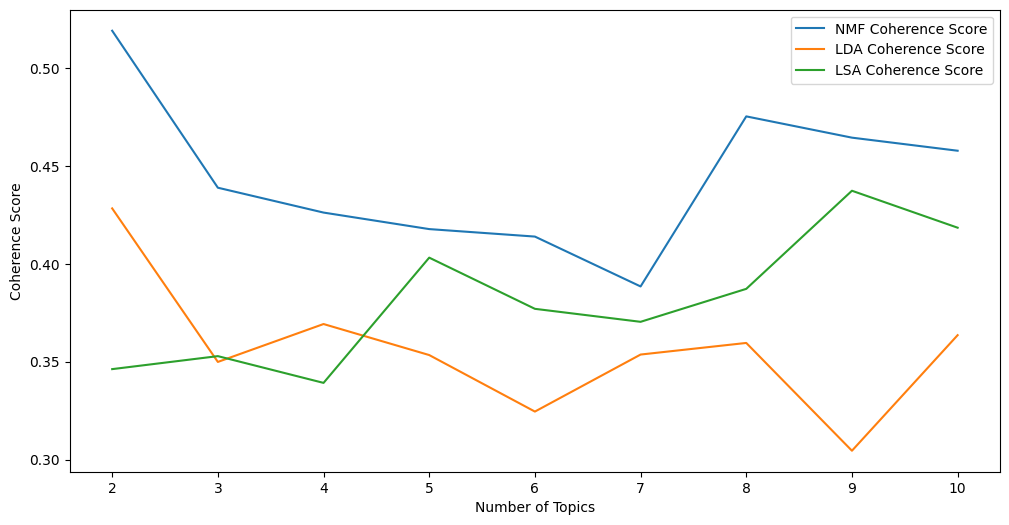

Optimal number of topics for NMF: 2
Optimal number of topics for LDA: 2
Optimal number of topics for LSA: 9


In [6]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pytz
from datetime import datetime, time
import re
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.metrics import silhouette_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import random
import time as Time

def topic_modeling(df, n_topics, max_features=500):
    print('Vectorizing on full data for tfidf matrix and topic modelling...')
    vectorizer = TfidfVectorizer(max_features=max_features, min_df=5, max_df=0.95, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df['preprocessed_text'])
    feature_names = vectorizer.get_feature_names_out()
    
    nmf_model = NMF(n_components=n_topics, random_state=42)
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lsa_model = TruncatedSVD(n_components=n_topics, random_state=42)
    
    nmf_output = nmf_model.fit_transform(tfidf_matrix)
    lda_output = lda_model.fit_transform(tfidf_matrix)
    lsa_output = lsa_model.fit_transform(tfidf_matrix)
    
    return nmf_output, lda_output, lsa_output, feature_names, nmf_model, lda_model, lsa_model

def add_topic_columns(df, nmf_output, lda_output, lsa_output, n_topics):
    for i in range(n_topics):
        df[f'nmf_topic_{i}'] = nmf_output[:, i]
        df[f'lda_topic_{i}'] = lda_output[:, i]
        df[f'lsa_topic_{i}'] = lsa_output[:, i]
    return df

def get_optimal_topics(df, max_topics=40, max_features=500, sample_num=10000):
    train_size = int(0.8 * len(df))
    train_df = df[:train_size]
    sample_df = train_df.sample(n=sample_num, random_state=42)
    # sample_df = train_df.sample(n=int(sample_rate * len(df)), random_state=42)

    print('Preprocessing text for optimal topics...')
    sample_df['preprocessed_text'] = sample_df['preprocessed_text'].fillna('')
    preprocessed_texts = sample_df['preprocessed_text'].astype(str).str.split().tolist()

    preprocessed_texts = [text for text in preprocessed_texts if text]

    if not preprocessed_texts:
        raise ValueError("No valid preprocessed texts found in the sample.")

    dictionary = Dictionary(preprocessed_texts)
    dictionary.filter_extremes(no_below=5, no_above=0.95)

    print('Vectorizing on sample for tfidf matrix and topic modelling...')
    vectorizer = TfidfVectorizer(max_features=max_features, min_df=5, max_df=0.95, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(sample_df['preprocessed_text'])
    feature_names = vectorizer.get_feature_names_out()

    results = []
    print("Determining optimal number of topics...")
    for n_topics in tqdm(range(2, max_topics + 1), desc="Evaluating topic numbers"):
        nmf_model = NMF(n_components=n_topics, random_state=42)
        lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lsa_model = TruncatedSVD(n_components=n_topics, random_state=42)

        start = Time.time()
        nmf_output = nmf_model.fit_transform(tfidf_matrix)
        end = Time.time()
        print(f"NMF time: {end-start:.4f}")    
    
        start = Time.time()
        lda_output = lda_model.fit_transform(tfidf_matrix)
        end = Time.time()
        print(f"LDA time: {end-start:.4f}")
        
        start = Time.time()
        lsa_output = lsa_model.fit_transform(tfidf_matrix)
        end = Time.time()
        print(f"LSA time: {end-start:.4f}")
        
        nmf_coherence = calculate_coherence_score(nmf_model, preprocessed_texts, dictionary, feature_names)
        lda_coherence = calculate_coherence_score(lda_model, preprocessed_texts, dictionary, feature_names)
        lsa_coherence = calculate_coherence_score(lsa_model, preprocessed_texts, dictionary, feature_names)

        nmf_score = silhouette_score(tfidf_matrix, np.argmax(nmf_output, axis=1))
        lda_score = silhouette_score(tfidf_matrix, np.argmax(lda_output, axis=1))
        lsa_score = silhouette_score(tfidf_matrix, np.argmax(lsa_output, axis=1))

        results.append({
            'n_topics': n_topics,
            'nmf_coherence': nmf_coherence,
            'lda_coherence': lda_coherence,
            'lsa_coherence': lsa_coherence,
            'nmf_silhouette': nmf_score,
            'lda_silhouette': lda_score,
            'lsa_silhouette': lsa_score
        })

    results_df = pd.DataFrame(results)
    optimal_nmf_topics = results_df.loc[results_df['nmf_coherence'].idxmax(), 'n_topics']
    optimal_lda_topics = results_df.loc[results_df['lda_coherence'].idxmax(), 'n_topics']
    optimal_lsa_topics = results_df.loc[results_df['lsa_coherence'].idxmax(), 'n_topics']

    plt.figure(figsize=(12, 6))
    plt.plot(results_df['n_topics'], results_df['nmf_coherence'], label='NMF Coherence Score')
    plt.plot(results_df['n_topics'], results_df['lda_coherence'], label='LDA Coherence Score')
    plt.plot(results_df['n_topics'], results_df['lsa_coherence'], label='LSA Coherence Score')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.legend()
    plt.show()

    return optimal_nmf_topics, optimal_lda_topics, optimal_lsa_topics

df = pd.read_csv('optimized.csv')
optimal_nmf_topics, optimal_lda_topics, optimal_lsa_topics = get_optimal_topics(df.drop_duplicates(), max_topics=10, sample_num=1000)

print(f"Optimal number of topics for NMF: {optimal_nmf_topics}")
print(f"Optimal number of topics for LDA: {optimal_lda_topics}")
print(f"Optimal number of topics for LSA: {optimal_lsa_topics}")


<span style="color:crimson">On average, LDA takes 79 times as long as NMF</span>


# NMF ONLY

In [5]:
def topic_modeling(df, n_topics, max_features=500):
    print('Vectorizing on full data for tfidf matrix and topic modelling...')
    vectorizer = TfidfVectorizer(max_features=max_features, min_df=5, max_df=0.95, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df['preprocessed_text'])
    feature_names = vectorizer.get_feature_names_out()
    
    print('Performing NMF modelling...')
    nmf_model = NMF(n_components=n_topics, random_state=42)
    nmf_output = nmf_model.fit_transform(tfidf_matrix)
    
    return nmf_output, feature_names, nmf_model

def add_topic_columns(df, nmf_output, n_topics):
    for i in range(n_topics):
        df[f'nmf_topic_{i}'] = nmf_output[:, i]
    return df

def calculate_coherence_score(model, texts, dictionary, feature_names):
    topics = [
        [feature_names[i] for i in topic.argsort()[:-11:-1]]
        for topic in model.components_
    ]
    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

def get_optimal_topics(df, max_topics=40, max_features=500, sample_num=10000, patience=5):
    train_size = int(0.8 * len(df))
    train_df = df[:train_size]
    sample_df = train_df.sample(n=sample_num, random_state=42)

    print('Preprocessing text for optimal topics...')
    sample_df['preprocessed_text'] = sample_df['preprocessed_text'].fillna('')
    preprocessed_texts = sample_df['preprocessed_text'].astype(str).str.split().tolist()

    # Filter out empty lists
    preprocessed_texts = [text for text in preprocessed_texts if text]

    if not preprocessed_texts:
        raise ValueError("No valid preprocessed texts found in the sample.")

    dictionary = Dictionary(preprocessed_texts)
    dictionary.filter_extremes(no_below=5, no_above=0.95)

    print('Vectorizing on sample for tfidf matrix and topic modelling...')
    vectorizer = TfidfVectorizer(max_features=max_features, min_df=5, max_df=0.95, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(sample_df['preprocessed_text'])
    feature_names = vectorizer.get_feature_names_out()

    results = []
    print("Determining optimal number of topics...")
    best_coherence = -np.inf
    best_n_topics = 0
    no_improvement_counter = 0

    for n_topics in tqdm(range(2, max_topics + 1), desc="Evaluating topic numbers"):
        nmf_model = NMF(n_components=n_topics, random_state=42)

        # start = Time.time()
        nmf_output = nmf_model.fit_transform(tfidf_matrix)
        # end = Time.time()
        # print(f"NMF time: {end-start:.4f}")    
    
        nmf_coherence = calculate_coherence_score(nmf_model, preprocessed_texts, dictionary, feature_names)
        nmf_score = silhouette_score(tfidf_matrix, np.argmax(nmf_output, axis=1))

        results.append({
            'n_topics': n_topics,
            'nmf_coherence': nmf_coherence,
            'nmf_silhouette': nmf_score
        })

        if nmf_coherence > best_coherence:
            best_coherence = nmf_coherence
            best_n_topics = n_topics
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        if no_improvement_counter >= patience:
            print(f"Early stopping at {n_topics} topics due to no improvement in coherence score for {patience} iterations.")
            break

    results_df = pd.DataFrame(results)
    optimal_nmf_topics = best_n_topics

    plt.figure(figsize=(12, 6))
    plt.plot(results_df['n_topics'], results_df['nmf_coherence'], label='NMF Coherence Score')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.legend()
    plt.show()

    return optimal_nmf_topics


Preprocessing text for optimal topics...
Vectorizing on sample for tfidf matrix and topic modelling...
Determining optimal number of topics...


Evaluating topic numbers:  63%|██████▎   | 12/19 [57:25<33:29, 287.14s/it]

Early stopping at 14 topics due to no improvement in coherence score for 5 iterations.


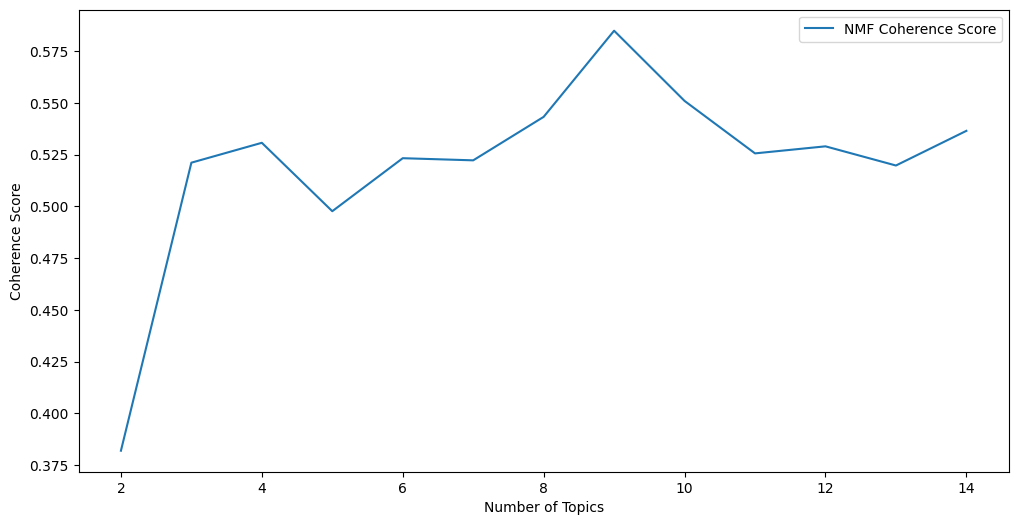

Optimal number of topics for NMF: 9


In [19]:

optimal_nmf_topics = get_optimal_topics(df.drop_duplicates(), max_topics=20, sample_num=100000)

print(f"Optimal number of topics for NMF: {optimal_nmf_topics}")


In [3]:
import torch
from tqdm import tqdm
import numpy as np
import gc

def finbert_sentiment(texts, model, tokenizer, batch_size=8, chunk_size=1000, device='cuda'):
    results = []
    model.eval()
    model.to(device)

    for i in tqdm(range(0, len(texts), chunk_size)):
        chunk = texts[i:i+chunk_size]
        chunk_results = []

        for j in range(0, len(chunk), batch_size):
            batch_texts = chunk[j:j+batch_size]
            
            # Tokenize and encode the batch
            inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            # Process the batch
            with torch.no_grad():
                outputs = model(**inputs)
                predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
                chunk_results.extend(predictions.cpu().numpy())
            
            # Clear memory
            del inputs, outputs, predictions
            torch.cuda.empty_cache()
        
        results.extend(chunk_results)
        
        # Clear memory after processing each chunk
        gc.collect()
        torch.cuda.empty_cache()

    return np.array(results)


In [ ]:
# Load FinBERT model for sentiment analysis
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert").to(device)
model = model.half()  # Convert to float16

print("Performing sentiment analysis...")
sentiment_scores = finbert_sentiment(df['body'].tolist(), model=model, tokenizer=tokenizer, batch_size=128)
df[['sentiment_negative', 'sentiment_neutral', 'sentiment_positive']] = sentiment_scores

print("Calculating tweet reach...")
df['tweet_reach'] = df.apply(calculate_tweet_reach, axis=1)

In [1]:
import pandas as pd
# df['sentiment_trend'] = calculate_sentiment_trend(df)
# # df['']
# df.to_csv('sentiments.csv')
# Tool.sound()
df = pd.read_csv('sentiments.csv')

In [6]:
df = df.dropna(subset=['preprocessed_text'])
# optimal_nmf_topics, optimal_lda_topics = 4, 3
optimal_nmf_topics = 9
print("Performing final topic modeling...")
nmf_output, feature_names, nmf_model = topic_modeling(df, optimal_nmf_topics, max_features=500)

print("Adding topic columns to DataFrame...")
df = add_topic_columns(df, nmf_output, optimal_nmf_topics)

print("Calculating sentiment score...")
df['sentiment_score'] = df['sentiment_positive'] - df['sentiment_negative']

df.to_csv('nmf_all_unaggregated.csv')


Performing final topic modeling...
Vectorizing on full data for tfidf matrix and topic modelling...
Performing NMF modelling...
Adding topic columns to DataFrame...
Calculating sentiment score...


In [18]:
import numpy as np
import pandas as pd

def credibility_weighted_aggregation(group):
    weights = group['tweet_reach']
    
    result = {
        'avg_sentiment': np.average(group['sentiment_score'], weights=weights),
        'avg_neutral_sentiment': np.average(group['sentiment_neutral'], weights=weights),        
        'avg_positive_sentiment': np.average(group['sentiment_positive'], weights=weights),
        'avg_negative_sentiment': np.average(group['sentiment_negative'], weights=weights),
        'total_engagement': weights.sum(),
        'total_reach': group['tweet_reach'].sum(),
    }
    
    nmf_cols = [col for col in group.columns if col.startswith('nmf_topic_')]
    for col in nmf_cols:
        result[col] = np.average(group[col], weights=weights)
    
    lda_cols = [col for col in group.columns if col.startswith('lda_topic_')]
    for col in lda_cols:
        result[col] = np.average(group[col], weights=weights)

    tweet_count = len(group)
    result['avg_reach_per_tweet'] = result['total_reach'] / tweet_count if tweet_count > 0 else 0
    result['avg_engagement_per_tweet'] = result['total_engagement'] / tweet_count if tweet_count > 0 else 0
    
    return pd.Series(result)

def attention_weighted_aggregation(group):
    weights = group['comment_num'] + group['retweet_num'] + group['like_num']
    
    # Check if all weights are zero
    if weights.sum() == 0:
        # If all weights are zero, use equal weights
        weights = pd.Series([1] * len(group))
    
    result = {
        'avg_sentiment': np.average(group['sentiment_score'], weights=weights),
        'avg_neutral_sentiment': np.average(group['sentiment_neutral'], weights=weights),        
        'avg_positive_sentiment': np.average(group['sentiment_positive'], weights=weights),
        'avg_negative_sentiment': np.average(group['sentiment_negative'], weights=weights),
        'total_engagement': weights.sum(),
        'total_reach': group['tweet_reach'].sum(),
        'tweet_volume': len(group)  
    }
    
    nmf_cols = [col for col in group.columns if col.startswith('nmf_topic_')]
    for col in nmf_cols:
        result[col] = np.average(group[col], weights=weights)
    
    lda_cols = [col for col in group.columns if col.startswith('lda_topic_')]
    for col in lda_cols:
        result[col] = np.average(group[col], weights=weights)
    
    tweet_count = len(group)
    result['avg_reach_per_tweet'] = result['total_reach'] / tweet_count if tweet_count > 0 else 0
    result['avg_engagement_per_tweet'] = result['total_engagement'] / tweet_count if tweet_count > 0 else 0
    
    return pd.Series(result)

def volume_based_aggregation(group):
    tweet_count = len(group)
    
    result = {
        'tweet_volume': tweet_count,
        'avg_sentiment': group['sentiment_score'].mean(),
        'avg_neutral_sentiment': group['sentiment_neutral'].mean(),
        'avg_positive_sentiment': group['sentiment_positive'].mean(),
        'avg_negative_sentiment': group['sentiment_negative'].mean(),
    }
    
    nmf_cols = [col for col in group.columns if col.startswith('nmf_topic_')]
    for col in nmf_cols:
        result[f'{col}_avg'] = group[col].mean()
    
    result['total_reach'] = group['tweet_reach'].sum()
    result['avg_reach_per_tweet'] = result['total_reach'] / tweet_count if tweet_count > 0 else 0
    result['total_engagement'] = group['comment_num'].sum() + group['retweet_num'].sum() + group['like_num'].sum()
    result['avg_engagement_per_tweet'] = result['total_engagement'] / tweet_count if tweet_count > 0 else 0
    
    return pd.Series(result)

df = pd.read_csv('nmf_all_unaggregated.csv')
df = df.drop(columns='Unnamed: 0')

grouped = df.groupby(['market_date', 'ticker_symbol'])

# daily_credibility_weighted = grouped.apply(credibility_weighted_aggregation).reset_index()
# daily_attention_weighted = grouped.apply(attention_weighted_aggregation).reset_index()
daily_volume_aggregated = grouped.apply(volume_based_aggregation).reset_index()

# daily_credibility_weighted.to_csv('./test_csvs/credibility_by_ticker.csv', index=False)
# daily_attention_weighted.to_csv('./test_csvs/attention_by_ticker.csv', index=False)
daily_volume_aggregated.to_csv('./test_csvs/nmf_volume.csv', index=False)


C:\Users\Adil Rehman\AppData\Local\Temp\ipykernel_3000\1378733447.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_volume_aggregated = grouped.apply(volume_based_aggregation).reset_index()


Implemented proper time zone handling.

Used only tweets up to market close for each day's features.

Split the data into training and testing sets before model selection and training.

Ensured all feature engineering steps are performed separately on training and testing data.



____ 

# LSA ONLY

Preprocessing text for optimal topics...
Vectorizing on sample for tfidf matrix and topic modelling...
Determining optimal number of topics...


Evaluating topic numbers:  26%|██▋       | 5/19 [20:02<56:06, 240.50s/it]  

Early stopping at 7 topics due to no improvement in coherence score for 5 iterations.


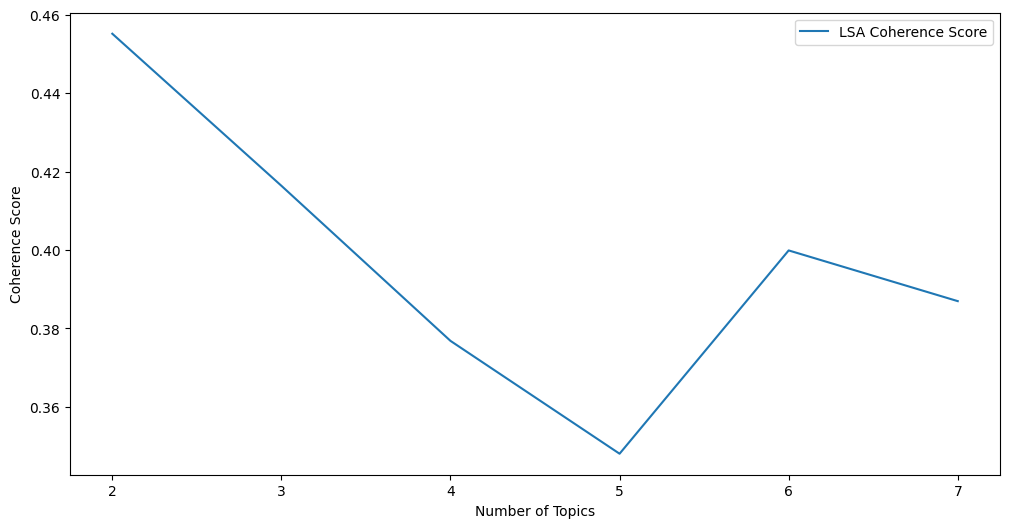

Optimal number of topics for LSA: 2


In [9]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from tqdm import tqdm
import matplotlib.pyplot as plt

def topic_modeling(df, n_topics, max_features=500):
    print('Vectorizing on full data for tfidf matrix and topic modelling...')
    vectorizer = TfidfVectorizer(max_features=max_features, min_df=5, max_df=0.95, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df['preprocessed_text'])
    feature_names = vectorizer.get_feature_names_out()
    
    print('Performing LSA modelling...')
    lsa_model = TruncatedSVD(n_components=n_topics, random_state=42)
    lsa_output = lsa_model.fit_transform(tfidf_matrix)
    
    return lsa_output, feature_names, lsa_model

def add_topic_columns(df, lsa_output, n_topics):
    for i in range(n_topics):
        df[f'lsa_topic_{i}'] = lsa_output[:, i]
    return df

def calculate_coherence_score(model, texts, dictionary, feature_names):
    topics = [
        [feature_names[i] for i in topic.argsort()[:-11:-1]]
        for topic in model.components_
    ]
    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

def get_optimal_topics(df, max_topics=40, max_features=500, sample_num=10000, patience=5):
    train_size = int(0.8 * len(df))
    train_df = df[:train_size]
    sample_df = train_df.sample(n=sample_num, random_state=42)
    
    print('Preprocessing text for optimal topics...')
    sample_df['preprocessed_text'] = sample_df['preprocessed_text'].fillna('')
    preprocessed_texts = sample_df['preprocessed_text'].astype(str).str.split().tolist()
    
    preprocessed_texts = [text for text in preprocessed_texts if text]
    
    if not preprocessed_texts:
        raise ValueError("No valid preprocessed texts found in the sample.")
    
    dictionary = Dictionary(preprocessed_texts)
    dictionary.filter_extremes(no_below=5, no_above=0.95)
    
    print('Vectorizing on sample for tfidf matrix and topic modelling...')
    vectorizer = TfidfVectorizer(max_features=max_features, min_df=5, max_df=0.95, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(sample_df['preprocessed_text'])
    feature_names = vectorizer.get_feature_names_out()
    
    results = []
    print("Determining optimal number of topics...")
    best_coherence = -np.inf
    best_n_topics = 0
    no_improvement_counter = 0
    
    for n_topics in tqdm(range(2, max_topics + 1), desc="Evaluating topic numbers"):
        lsa_model = TruncatedSVD(n_components=n_topics, random_state=42)
        
        lsa_output = lsa_model.fit_transform(tfidf_matrix)
        
        lsa_coherence = calculate_coherence_score(lsa_model, preprocessed_texts, dictionary, feature_names)
        lsa_score = silhouette_score(tfidf_matrix, np.argmax(lsa_output, axis=1))
        
        results.append({
            'n_topics': n_topics,
            'lsa_coherence': lsa_coherence,
            'lsa_silhouette': lsa_score
        })
        
        if lsa_coherence > best_coherence:
            best_coherence = lsa_coherence
            best_n_topics = n_topics
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1
        
        if no_improvement_counter >= patience:
            print(f"Early stopping at {n_topics} topics due to no improvement in coherence score for {patience} iterations.")
            break
    
    results_df = pd.DataFrame(results)
    optimal_lsa_topics = best_n_topics
    
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['n_topics'], results_df['lsa_coherence'], label='LSA Coherence Score')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.legend()
    plt.show()
    
    return optimal_lsa_topics

df = pd.read_csv('sentiments.csv')
optimal_lsa_topics = get_optimal_topics(df.drop_duplicates(), max_topics=20, sample_num=100000)

print(f"Optimal number of topics for LSA: {optimal_lsa_topics}")

df = df.dropna(subset=['preprocessed_text'])


In [10]:

optimal_lsa_topics = optimal_lsa_topics  
print("Performing final topic modeling...")
lsa_output, feature_names, lsa_model = topic_modeling(df, optimal_lsa_topics, max_features=500)

print("Adding topic columns to DataFrame...")
df = add_topic_columns(df, lsa_output, optimal_lsa_topics)

Performing final topic modeling...
Vectorizing on full data for tfidf matrix and topic modelling...
Performing LSA modelling...
Adding topic columns to DataFrame...


In [11]:
print("Calculating sentiment score...")
df['sentiment_score'] = df['sentiment_positive'] - df['sentiment_negative']


Calculating sentiment score...


In [12]:
import numpy as np
import pandas as pd

def volume_based_aggregation(group):
    tweet_count = len(group)
    
    result = {
        'tweet_volume': tweet_count,
        'avg_sentiment': group['sentiment_score'].mean(),
        'avg_neutral_sentiment': group['sentiment_neutral'].mean(),
        'avg_positive_sentiment': group['sentiment_positive'].mean(),
        'avg_negative_sentiment': group['sentiment_negative'].mean(),
    }
    
    lsa_cols = [col for col in group.columns if col.startswith('lsa_topic_')]
    for col in lsa_cols:
        result[f'{col}_avg'] = group[col].mean()
    
    result['total_reach'] = group['tweet_reach'].sum()
    result['avg_reach_per_tweet'] = result['total_reach'] / tweet_count if tweet_count > 0 else 0
    result['total_engagement'] = group['comment_num'].sum() + group['retweet_num'].sum() + group['like_num'].sum()
    result['avg_engagement_per_tweet'] = result['total_engagement'] / tweet_count if tweet_count > 0 else 0
    
    return pd.Series(result)

df.to_csv('lsa_all_unaggregated.csv')
df = pd.read_csv('lsa_all_unaggregated.csv')
df = df.drop(columns='Unnamed: 0')

grouped = df.groupby(['market_date', 'ticker_symbol'])

# daily_credibility_weighted = grouped.apply(credibility_weighted_aggregation).reset_index()
# daily_attention_weighted = grouped.apply(attention_weighted_aggregation).reset_index()
daily_volume_aggregated = grouped.apply(volume_based_aggregation).reset_index()

# daily_credibility_weighted.to_csv('./test_csvs/credibility_by_ticker.csv', index=False)
# daily_attention_weighted.to_csv('./test_csvs/attention_by_ticker.csv', index=False)
daily_volume_aggregated.to_csv('./test_csvs/lsa_volume.csv', index=False)


C:\Users\Adil Rehman\AppData\Local\Temp\ipykernel_16884\4283519305.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_volume_aggregated = grouped.apply(volume_based_aggregation).reset_index()
